In [ ]:
# [Step 1. 데이터 수집하기]
import os

# 데이터 저장 폴더 생성 및 이동
!mkdir -p data
# 데이터 다운로드
!wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv -O data/ChatbotData.csv

# 라이브러리 설치 (코랩 GPU 환경 최적화)
!pip install sentencepiece

--2026-02-05 08:48:37--  https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv [following]
--2026-02-05 08:48:37--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘data/ChatbotData.csv’

data/ChatbotData.cs 100%[===================>] 868.99K  --.-KB/s    in 0.03s   

2026-02-05 08:48:39 (30.4 MB/s) - ‘data/ChatbotData.csv’ saved [889842/889842]



In [ ]:
# [Step 2. 데이터 전처리하기] & [Step 3. SentencePiece 사용하기]
import pandas as pd
import re
import sentencepiece as spm
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# [루브릭 3번: 한국어 전처리를 통해 학습 데이터셋 구축]
def preprocess_sentence(sentence):
    sentence = sentence.strip()
    # 구두점 분리
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 한글, 영어, 숫자, 주요 구두점 제외 제거
    sentence = re.sub(r"[^가-힣?.!,0-9a-zA-Z]+", " ", sentence)
    return sentence.strip()

# 데이터 로드
data = pd.read_csv('data/ChatbotData.csv')
questions = [preprocess_sentence(q) for q in data['Q']]
answers = [preprocess_sentence(a) for a in data['A']]

# SentencePiece 학습을 위한 텍스트 파일 생성
with open('chatbot.txt', 'w', encoding='utf-8') as f:
    for line in questions + answers:
        f.write(line + '\n')

# SentencePiece 모델 학습 (어휘 사전 8000개)
spm.SentencePieceTrainer.Train('--input=chatbot.txt --model_prefix=korean_spm --vocab_size=8000')
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# [루브릭 3번: 토크나이징 및 병렬 데이터 구축]
MAX_LENGTH = 40

def encode(sentence):
    # <s>: 1, </s>: 2
    return [s.bos_id()] + s.EncodeAsIds(sentence) + [s.eos_id()]

tokenized_questions = [encode(q) for q in questions]
tokenized_answers = [encode(a) for a in answers]

# 패딩 처리 (모든 문장 길이를 40으로 통일)
tokenized_questions = pad_sequences(tokenized_questions, maxlen=MAX_LENGTH, padding='post')
tokenized_answers = pad_sequences(tokenized_answers, maxlen=MAX_LENGTH, padding='post')

# 텐서플로우 Dataset 구축 (Teacher Forcing을 위한 슬라이싱)
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': tokenized_questions,
        'dec_inputs': tokenized_answers[:, :-1] # 마지막 토큰 제외
    },
    tokenized_answers[:, 1:] # 시작 토큰 제외
))
dataset = dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

print("✅ 데이터셋 구축 완료 (Step 2, 3)")

✅ 데이터셋 구축 완료 (Step 2, 3)


In [ ]:
# [Step 4. 모델 구성하기]

# 1. 포지셔널 인코딩
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        return pos_encoding[tf.newaxis, ...]

    def call(self, inputs):
        if isinstance(inputs, tf.SparseTensor):
            inputs = tf.sparse.to_dense(inputs)
        return tf.cast(inputs, tf.float32) + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# 2. 멀티 헤드 어텐션 (고유 이름을 받을 수 있도록 수정)
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        query = self.split_heads(self.query_dense(query), batch_size)
        key = self.split_heads(self.key_dense(key), batch_size)
        value = self.split_heads(self.value_dense(value), batch_size)

        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        if mask is not None:
            logits += (mask * -1e9)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)

        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, -1, self.d_model))
        return self.dense(concat_attention)

# 3. 인코더 레이어 (이름 충돌 방지)
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # MultiHeadAttention에 유니크한 이름 부여
    attention = MultiHeadAttention(d_model, num_heads, name=f"{name}_attention")({
          'query': inputs, 'key': inputs, 'value': inputs, 'mask': padding_mask
    })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 4. 디코더 레이어 (이름 충돌 방지)
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 각 Attention 레이어에 유니크한 이름 부여
    attention1 = MultiHeadAttention(d_model, num_heads, name=f"{name}_attention_1")({
          'query': inputs, 'key': inputs, 'value': inputs, 'mask': look_ahead_mask
    })
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    attention2 = MultiHeadAttention(d_model, num_heads, name=f"{name}_attention_2")({
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, 'mask': padding_mask
    })
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs, name=name)

# 5. 최종 모델 조립
def transformer(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, name='enc_padding_mask')(inputs)
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, name='look_ahead_mask')(dec_inputs)
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, name='dec_padding_mask')(inputs)

    enc_emb = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    enc_emb *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    enc_outputs = PositionalEncoding(vocab_size, d_model)(enc_emb)

    for i in range(num_layers):
        enc_outputs = encoder_layer(units=dff, d_model=d_model, num_heads=num_heads, dropout=dropout, name=f"encoder_layer_{i}")([enc_outputs, enc_padding_mask])

    dec_emb = tf.keras.layers.Embedding(vocab_size, d_model)(dec_inputs)
    dec_emb *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    dec_outputs = PositionalEncoding(vocab_size, d_model)(dec_emb)

    for i in range(num_layers):
        dec_outputs = decoder_layer(units=dff, d_model=d_model, num_heads=num_heads, dropout=dropout, name=f"decoder_layer_{i}")([dec_outputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

print("✅ Step 4: 레이어 이름 충돌 해결 및 모델 설계 완료!")

✅ Step 4: 레이어 이름 충돌 해결 및 모델 설계 완료!


🚀 학습을 시작합니다. GPU 상태를 확인하세요.
Epoch 1/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 50s 113ms/step - accuracy: 0.0282 - loss: 1.6210
Epoch 2/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.0671 - loss: 0.9747
Epoch 3/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.0900 - loss: 0.7451
Epoch 4/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.1081 - loss: 0.5819
Epoch 5/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.1248 - loss: 0.4526
Epoch 6/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.1368 - loss: 0.3620
Epoch 7/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.1514 - loss: 0.2685
Epoch 8/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.1665 - loss: 0.1825
Epoch 9/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.1751 - loss: 0.1312
Epoch 10/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.1822 - loss: 0.0970
Epoch 11/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.1870 - loss: 0.0733
Epoch 12/30

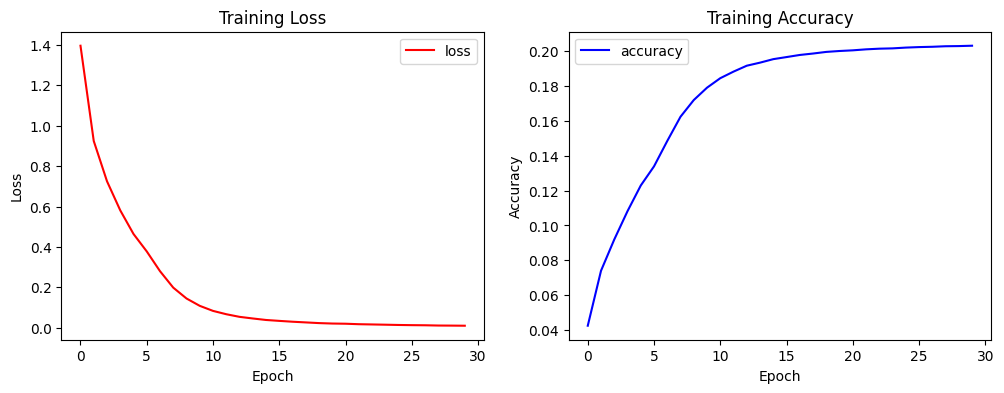

✅ 학습 및 성능 지표 시각화가 완료되었습니다!


In [ ]:
# [Step 4-1. 모델 컴파일 및 학습하기 (시각화 포함)]
import matplotlib.pyplot as plt
import tensorflow as tf

# 1. 모델 생성에 필요한 마스킹 함수 다시 정의 (NameError 방지)
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

# 2. 하이퍼파라미터 및 손실 함수 설정
D_MODEL = 256
MAX_LENGTH = 40
EPOCHS = 30 # 성능을 확인하기 위해 30회 정도 추천합니다.

def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    return tf.reduce_mean(loss)

# 3. 모델 생성 및 컴파일 [루브릭 2번: 안정적 수렴 진행]
learning_rate = CustomSchedule(D_MODEL, warmup_steps=1000)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# 이전에 정의한 transformer 함수를 호출합니다.
model = transformer(
    vocab_size=8000,
    num_layers=2,
    dff=512,
    d_model=D_MODEL,
    num_heads=8,
    dropout=0.3
)

model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# 4. 학습 시작 및 기록 저장
print("🚀 학습을 시작합니다. GPU 상태를 확인하세요.")
history = model.fit(dataset, epochs=EPOCHS)

# 5. [성능 파악] 손실(Loss) 및 정확도(Accuracy) 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy', color='blue')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

print("✅ 학습 및 성능 지표 시각화가 완료되었습니다!")

In [ ]:
# [Step 5. 모델 평가하기]

# [루브릭 1번: 한국어 입력에 대해 한국어로 답변하는 함수 구현]
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)
    # 입력 텐서 변환
    enc_input = tf.convert_to_tensor([encode(sentence)], dtype=tf.int32)
    output_sequence = tf.expand_dims([s.bos_id()], 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[enc_input, output_sequence], training=False)
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 종료 토큰이면 중단
        if tf.equal(predicted_id, s.eos_id()): break
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return s.DecodeIds(output_sequence.numpy().squeeze().tolist())

# 확인 [루브릭 1번 평가 기준: 맥락에 맞는 한국어 답변]
test_set = ['안녕하세요', '배고파', '오늘 날씨 어때?', '고민이 있어']
for q in test_set:
    print(f"질문: {q} -> 답변: {decoder_inference(q)}")

질문: 안녕하세요 -> 답변: 안녕하세요 .
질문: 배고파 -> 답변: 뭐 좀 챙겨드세요 .
질문: 오늘 날씨 어때? -> 답변: 저 드세요 .
질문: 고민이 있어 -> 답변: 거리를 두세요 .


In [ ]:
# 회고
# 처음에는 학습을 시키지 않고 바로 답변하게 했더니 중복되는 말을 많이 하는 등의 문제가 생겼음
# 이를 해결하기 위해 에폭을 30으로 늘리고 진행해보니 어느정도 가벼운 질문에 대한 답은 잘 했지만 구체적으로는 답변이 엉성했음. 예를 들어 고민이 있다는 말에 생각을 종이에 끄세요라고 함.
# 모델이 단순히 답을 외우기만 했던 것 같아서 dropout을 0.1에서 0.3으로 변경하는 등의 노력 필요
